## Lesson 1

Guided video: https://forums.fast.ai/t/lesson-1-links-to-different-parts-in-video/27581

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Now we are going to import the fastai and related stuff.

In [2]:
from fastai import *
from fastai.vision import *

## Data

Here we are going to use a dataset which 37 categories of both dogs and cats. <br/>
It really doesn't matter whether cat or dog, all we need to know it there are 37 categories. <br/>
We are going to train a model which can identify them.

In [3]:
# This the dataset we are going to fetch.
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet'

In [5]:
data_path = untar_data(URLs.PETS); data_path

PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet')

Here's we use the function `untar_data`.<br/>
Basically it'll take a URL(str), download it and untar it.<br/>
Then it returns path object where which will be used later.

In [6]:
data_path.ls()

[PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/annotations')]

### Let's load images

Before we do that, we need to figure out how to get category names from these images. Since this is a well known dataset, there should be a way to do it :D

In [7]:
image_path = data_path/'images'
fnames = get_image_files(image_path);
print(len(fnames))
fnames[:5]

7390


[PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/basset_hound_137.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/Sphynx_45.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/newfoundland_79.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/havanese_163.jpg'),
 PosixPath('/home/arunoda_susiripala/.fastai/data/oxford-iiit-pet/images/japanese_chin_160.jpg')]

It seems like catgeory name is in the filename. So based on this we are going to create a fastai `DataBunch` object where we'll use it for the training purpose.
In order to get that we are going to use the follow `DataBlock` API.

For we'll use a regexp to pick the category name.

In [8]:
data = (
    ImageItemList
        .from_folder(image_path) # load images from a folder
        .random_split_by_pct() # split them to train and validate
        .label_from_re(r'/([^/]+)_[0-9]+.jpg$') # add labels to those images
        .transform(get_transforms(), size=224) # transform and and put all to a same size
        .databunch() # get the databunch
        .normalize(imagenet_stats) # normalize with the imagenet stats
)

In [9]:
print(data.classes)
len(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


37

See. This is our categories.

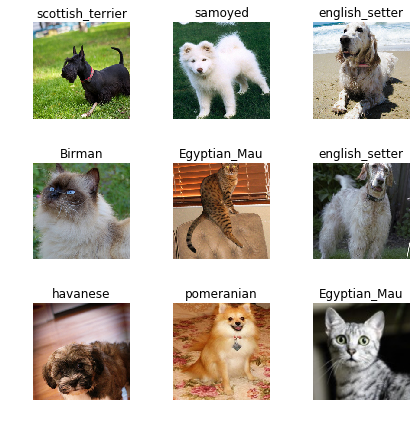

In [12]:
# Let's have a look at some random data
data.show_batch(3, figsize=(6,6))

## Training: resnet 34

Here we are training our dataset with a deep learning model called resnet. <br/>
It's an already train model which knows how to identify things in images.
So, we are going to build this on top of that. 

With that, we can reuse and do things speedly.<br>
This is something like, teaching a kid of speak a new lang who knows how to speak words.

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [14]:
learn.fit_one_cycle(4)

Here we've use `learn.fit_one_cycle` to start train our model. Usually we call a method called `fit` which is alaso available.

But `fit_one_cycle` is something new and 2018ish. (Jerammy said that :D)

Check the resuls above.
We are improving which each epoch(cycle).

In [15]:
# let's save this model. So, we don't need to start from scratch in the next time.
learn.save('lesson1-stage1')

## Inspect Result

Now we need to inspect some results and how we are doing here.

In [16]:
result = ClassificationInterpretation.from_learner(learn)

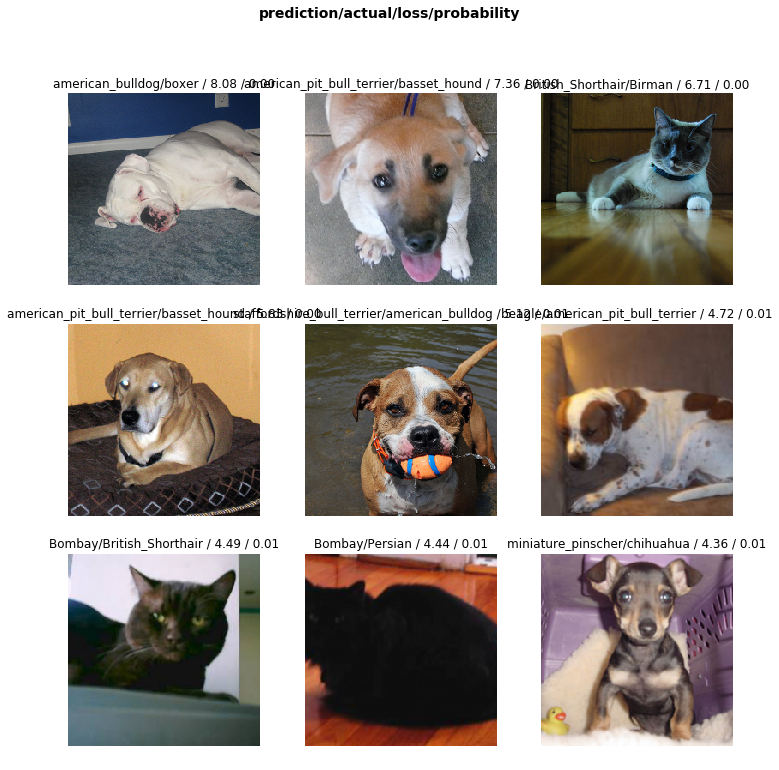

In [21]:
# Shows a list of incorrectly identified images
# This is just a way to browse these images
result.plot_top_losses(9, figsize=(12,12))

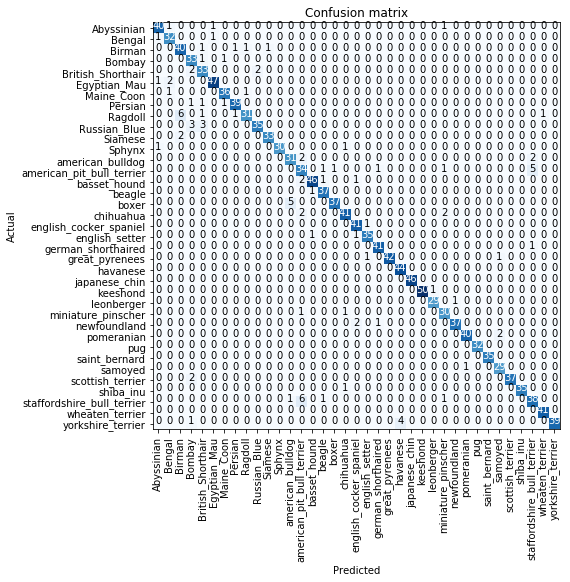

In [24]:
result.plot_confusion_matrix(figsize=(8,8))

Even though it's pretty useful, we cannot get anything here. It's too much details.  <br/>
So, we need to reduce it. For that we use this:

In [25]:
result.most_confused(2)

[('Ragdoll', 'Birman', 6),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('boxer', 'american_bulldog', 5),
 ('yorkshire_terrier', 'havanese', 4),
 ('Russian_Blue', 'Bombay', 3),
 ('Russian_Blue', 'British_Shorthair', 3)]

Here's the topped items from the confusion metrics. It's pretty hard identify these guys even for us. <br/>
So, the computer did a great job.

## Unfreezing

Basically, in the previous section we only train our model on top of the last layer of the resnet34. (Which is 34). <br/>.
No we are trying to train our model on all of them.

In [26]:
## This is that.
learn.unfreeze()

In [27]:
learn.fit_one_cycle(4)

This is unfreezing doesn't give us much benefit.
It's hard to say, we'll get a benefit or not by without trying it.

### Learning Rate

Here, learning rate could be the problem. Let's have a look at it. <br/>
First let's checkout the learning rate for our previous model.

In [28]:
learn.load('lesson1-stage1');

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Here `lr_find()` will start training by increasing the learning rate. When it finds out the optimal learning rate, it'll stop training. <br/>
That's what we can see above.

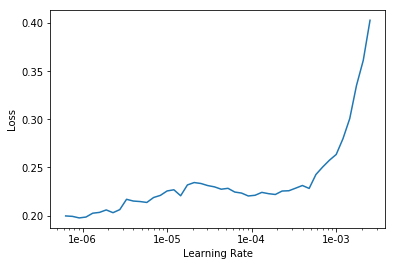

In [30]:
learn.recorder.plot()

As you can see above, the good learning rate is between 10^-6 to 10^-4.<br/>
But in the `.fit_one_cycle`, default learning rate is 10^-3. <br/>
That could be the reason for that. Let's try to change that.

In [31]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

In [32]:
learn.save('resnet34-unfreezed')

**That's a pretty good result**

## Different Model: Resnet 50

Here we are trying to use a different model called resnet50. In contrast to resnet34, this has nore nural network layers. <br/>
We learn about them later.

In [35]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [36]:
learn.fit_one_cycle(4)

In [37]:
learn.save('resnet50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


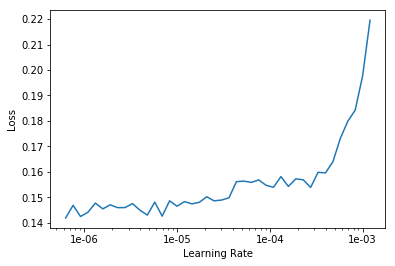

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

In [40]:
learn.save('resnet50-unfreeze')

## Model: Resnet152

This is just another model. The process is the same as above.

In [10]:
learn = create_cnn(data, models.resnet152, metrics=error_rate)

In [11]:
learn.fit_one_cycle(2)

In [12]:
learn.unfreeze()

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


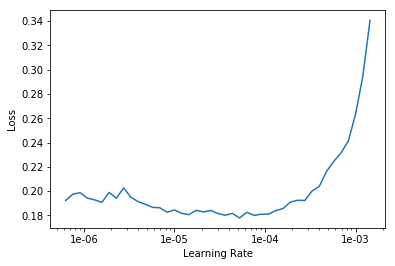

In [15]:
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(4, slice(1e-5, 1e-4))

This is a pretty good result. Since this model has more layers, it can learn better.
But it takes time.

In [19]:
learn.save('resnet152-unfreezed-after-4-epochs')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


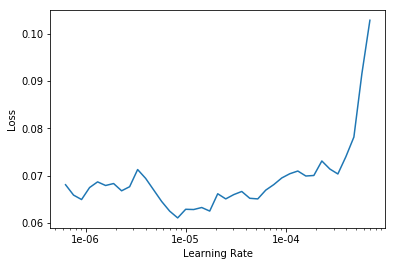

In [22]:
learn.lr_find()
learn.recorder.plot()

In [25]:
learn.load('resnet152-unfreezed-after-4-epochs');
learn.fit_one_cycle(4, slice(1e-5,1e-4))

It seems like the erorr_rate is isn't improving much.
So, we don't really need above set of epochs.

**Just like this, training is a trail and error process.**

# Research

This is a set of stuff we ran while I am trying to understand all of these.

### Case 1
Fit, unfreeze and fit with max_lr

This is the usual way to do this. Before unfreeze, we may need to need to decide on the learning rate.
When we are fitting all the layers, we should pass the corretc learning rate with `max_ls`

Total time: 01:51
epoch  train loss  valid loss  error_rate
1      1.163163    0.291988    0.093960    (00:30)
2      0.508505    0.240793    0.085235    (00:26)
3      0.335851    0.174600    0.051678    (00:27)
4      0.241489    0.173452    0.055705    (00:26)



Total time: 00:55
epoch  train loss  valid loss  error_rate
1      0.211216    0.165664    0.053020    (00:27)
2      0.184949    0.167273    0.054362    (00:27)



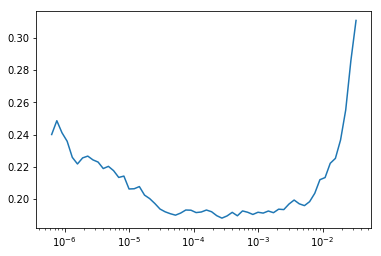

In [11]:
learn2 = create_cnn(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)
learn2.lr_find()
learn2.recorder.plot()
learn2.unfreeze()
learn2.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

### Case 2

Fit, unfreeze, fit

Here we unfreeze and fitting without modified learning rates. That's why the error rate is so high.

In [27]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)
learn2.unfreeze()
learn2.fit_one_cycle(2)

Total time: 01:44
epoch  train loss  valid loss  error_rate
1      1.177395    0.301522    0.094577    (00:26)
2      0.487977    0.225668    0.084656    (00:25)
3      0.307252    0.189310    0.061508    (00:26)
4      0.229580    0.181239    0.058862    (00:26)



Total time: 00:54
epoch  train loss  valid loss  error_rate
1      1.131546    1.537658    0.421958    (00:27)
2      0.655043    0.354331    0.113757    (00:27)



### Case 3
Fit for 6 epochs directly

This could result in overfitting.

In [28]:
learn2 = create_cnn(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(6)

Total time: 02:40
epoch  train loss  valid loss  error_rate
1      1.309131    0.334424    0.095238    (00:27)
2      0.553860    0.241669    0.080026    (00:26)
3      0.370115    0.205978    0.074735    (00:26)
4      0.270048    0.195635    0.068122    (00:26)
5      0.205317    0.182467    0.062169    (00:26)
6      0.171027    0.176030    0.059524    (00:27)



### Case 4

Fit, fit with max_lr

Here in the last 2 epochs, we are going to train with all layers with modified learning rates.
No one is really sure about what's going there.

In [25]:
learn2 = create_cnn(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4)
learn2.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

### Case 5

unfreeze, fit with max_lr.

This might work, but may need to try couple of more layers.

In [12]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.unfreeze()
learn2.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

Total time: 03:42
epoch  train loss  valid loss  error_rate
1      3.916172    3.127544    0.824161    (00:27)
2      2.871277    1.687004    0.333557    (00:27)
3      1.715563    0.800056    0.153020    (00:27)
4      1.056707    0.514616    0.102013    (00:27)
5      0.761249    0.408503    0.086577    (00:27)
6      0.643243    0.353329    0.081208    (00:27)
7      0.558056    0.337213    0.075168    (00:28)
8      0.565766    0.330909    0.075168    (00:27)



### Case 6

fit with max_lr from the beginning

last layers are getting trained with wrong learning rates. That might be the case.

In [32]:
learn2 = ConvLearner(data, models.resnet34, metrics=error_rate)
learn2.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

Total time: 01:49
epoch  train loss  valid loss  error_rate
1      3.931007    3.084067    0.822090    (00:27)
2      2.802922    1.784122    0.335317    (00:27)
3      2.057958    1.349792    0.236772    (00:27)
4      1.782516    1.282479    0.226852    (00:27)



## Training with a higher core model

## Training: resnet50

As the name suggested, this is a model with 50 layers. This seems to be working well with most cases pretty well.
But this may needs to tweaks as this needed more GPU memory.

> If this has GPU memory problems, reduce the following `bs`(batch size parameter values.

In [26]:
data = ImageDataBunch.from_name_re(image_path, fnames, pattern, ds_tfms=get_transforms(), size=224, bs=64);
data.normalize(imagenet_stats)

In [27]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)
learn.fit_one_cycle(5)

Total time: 02:31
epoch  train loss  valid loss  error_rate
1      0.734146    0.244882    0.083619    (00:30)
2      0.405343    0.193636    0.062371    (00:30)
3      0.284258    0.179527    0.065798    (00:30)
4      0.180800    0.158668    0.056888    (00:30)
5      0.125097    0.153993    0.056203    (00:30)



It's pretty good, compared to resnet34 without any modifications.

In [28]:
learn.save('lesson1-stage2')

In [22]:
learn.lr_find()

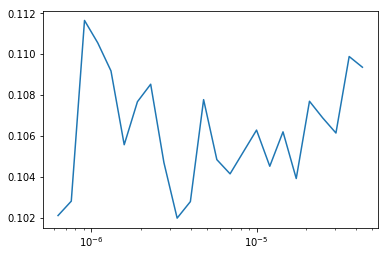

In [23]:
learn.recorder.plot()

In [24]:
learn.unfreeze()

In [25]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-5))

Total time: 01:14
epoch  train loss  valid loss  error_rate
1      0.114127    0.163489    0.055824    (00:37)
2      0.107130    0.164303    0.058580    (00:36)



**It's not improving much. So, we don't need to unfreeze here.**

In [26]:
data = ImageDataBunch.from_name_re(image_path, fnames, pattern, ds_tfms=get_transforms(), size=224, bs=64);
data.normalize(imagenet_stats)


NameError: name 'pattern' is not defined